# Topic Clustering using Sentence Embeddings

In [1]:
import os
import sys
PATH = '/home/piotr/projects/twitter'
PATH_DATA = os.path.join(PATH, 'data/clean/')
PATH_RESULTS = os.path.join(PATH, 'results/topics/kmeans')
PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
sys.path.append(os.path.join(PATH, 'src'))
START = '2020_02_22' #start date (first file)
END = '2020_07_20' #end date (last file)
TRAIN_SIZE = 0.1

In [2]:
import pickle
import gc
import numpy as np
import pandas as pd
from itertools import chain, product
from functools import partial
import re
import json
import pdb
import gc


import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import show
from tqdm.notebook import tqdm
tqdm.pandas()


from gensim.models import KeyedVectors
from nltk import FreqDist, word_tokenize
from twitter_models.embeddings import KTopicModel, KTopicModelCosine, DBSCANTopics
from twitter_tools.utils import read_files, batch, VectorDictLowMemory, VectorDict
import twitter_tools.evaluation.topics as evaluation
from sklearn.model_selection import StratifiedShuffleSplit


dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

Loading BokehJS ...

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Introduction
In this notebook, I evaluate Tweet topic clustering obtained through the method specified by Demszky et al. in accordance with the sentence embeddings method proposed by Arora et al. 2017. For each Tweet, its embedding was calculated as the weighted sum of its lemmatized tokens, where the weights where tokens' respective weights were inversly proportional to each token's probability of occurence, using a normalzing constant $a$, such that $w = \frac{a}{ap(w)}$ Clustering was done using Minibatch K Means clustering algorithm, using sample of 10% of the total unique tweets, stratified w.r.t the date and party alligiance, to ensure the representativeness of the results.

### Data loading
The data is loaded from the preprocessed files, additionally excluding the ids flagged as problematic by the analysis performed in the `preprocessing` notebook. The Tweets that included less than 50% of Polish vocabulary or were tagged as outliers are also removed. Below, I define a filter function which is used toegether with the data loader function `read_files` specified in the module `twitter_tools.utils`.

In [3]:
drop_users = json.load(open(os.path.join(PATH, 'results/cleaning/drop_users.json'), 'r'))
drop_tweets = json.load(open(os.path.join(PATH, 'results/cleaning/drop_tweets.json'), 'r'))
def filter_fun(df, drop_users, drop_tweets, drop_duplicates = True, cols = 'all'):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True)
    if cols != 'all':
        df = df[cols]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, cols = ['full_text','lemmatized','source'])

In [4]:
data = pd.DataFrame()
for dat in tqdm(read_files(PATH_DATA, day_from = START, day_to = END, dtype = dtypes, 
                           filter_fun = ff, method = 'pandas')):
    dat.drop_duplicates(subset = ['lemmatized'], inplace = True)
    dat.lemmatized = dat.lemmatized.apply(lambda x: x.split())
    dat = dat.groupby('source').apply(lambda x: x.sample(frac = TRAIN_SIZE, random_state = 1234))
    data = data.append(dat)
    gc.collect()
data.drop_duplicates(subset = ['full_text'], inplace = True)
text = data['lemmatized'].tolist()
data.reset_index(inplace = True, drop = True)
print(f'Data loadead. Train size {len(text)}')


Data loadead. Train size 558603


## Grid Search
To identify the optimal clustering hyperparameters (number of centroids `k` and the `a` inverse frequency weighting constant) I performed a grid search over a range of parameters, computing the silhuette score on 10% of the training data and obtaining the within-cluster sum of squares.

In [5]:
def grid_search(text:list, folder_results:str, path_embeddings:str, verbose = False, save = False):
    #set up grid:
    keys = params.keys(); combs = product(*params.values()) #keys + all combinations of parameters
    grid = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    #iterate
    for i, param in tqdm(enumerate(grid)): 
        ktp = KTopicModel(k = param["k"], a = param["a"], ncomp = param["ncomp"], path_embeddings = path_embeddings)
        
        #fit the model
        ktp.fit(text)
        #evaluate:
        grid[i]['silhuette'] = ktp.evaluate(text, sample_size = round(0.1 * len(text)), random_state = 1234)
        grid[i]['inertia'] = ktp.cluster.inertia_
        if verbose:
            print(f'Done evaluating {i} out of {len(grid)}. \
            K: {grid[i]["k"]} \
            A: {grid[i]["a"]} \
            Silhuette score {round(grid[i]["silhuette"], 4)}. \
            Inertia {round(grid[i]["inertia"], 4)}')
        #save:
        if save:
            pickle.dump(ktp, open(os.path.join(folder_results, f'cluster_n_{ktp.ncomp}_k_{ktp.k}_a_{ktp.a}.p'), 'wb'))
        del ktp
        gc.collect()
    return grid

### 1. Using pre-trained fasttext vectors (300-dimensional):

In [6]:
%%time
PATH_COMPARISON = os.path.join(PATH_RESULTS, 'grid_search_fasttext.json')
if os.path.isfile(PATH_COMPARISON):
    results = json.load(open(PATH_COMPARISON, 'r'))
else:
    #run grid search:
    params = {'k':list(range(5, 25, 2)), 'a':[1, 1e-1, 1e-2, 1e-3], 'ncomp':[0, 1, 2]}
    results = grid_search(data.lemmatized, PATH_RESULTS, PATH_EMBEDDINGS)
    json.dump(results, open(PATH_COMPARISON, 'w'))


CPU times: user 11h 19min 54s, sys: 2h 43min 41s, total: 14h 3min 35s
Wall time: 8h 19min 8s


### Evaluation methods:
The models were compared on the following criteria:

**1. Measures of clustering fit - silhuette score computed by bootstrapping and within-cluster sum of squares**

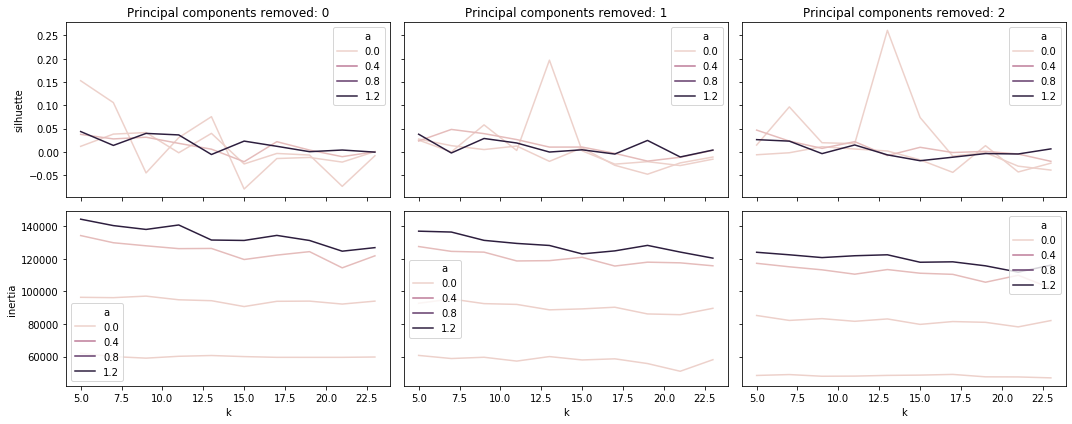

In [73]:
results = pd.DataFrame(results)
results['a'] = results['a'].astype(str)
fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True, sharey = 'row')
ax = ax.ravel()
for i, (val, subdf) in enumerate(df.groupby('ncomp')):
    sns.lineplot(x = "k", y = "silhuette", hue = "a", ax = ax[i], data = subdf)
    ax[i].set_title(f'Principal components removed: {val}')
for i, (val, subdf) in enumerate(df.groupby('ncomp')):
    sns.lineplot(x = "k", y = "inertia", hue = "a", ax = ax[i+3], data = subdf)
plt.tight_layout()
plt.show()
print(df.sort_values('silhuette', ascending = True))

**2. Closest word vectors to cluster centroids**

In [8]:
ktp = pickle.load(open('tmp.p','rb'))

In [10]:
PATH_EMBEDDINGS = '/home/piotr/nlp/glove/vectors.txt'
glove = VectorDict().read_file(PATH_EMBEDDINGS, dim = 50)
centroid_dict  = {k:c for k, c in enumerate(glove.most_similar_by_vectors(ktp.cluster.cluster_centers_, n = 10))}
centroid_dict_noscores = {k:[w[0] for w in v] for k, v in centroid_dict.items()}

In [11]:
import numpy as np
from tqdm import tqdm
from itertools import chain
from operator import itemgetter
from nltk import FreqDist
from twitter_tools.utils import batch
from bokeh.plotting import output_file, show, curdoc, figure
from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, Text, Circle, Plot, HoverTool, LinearAxis, Grid, Select, Dropdown
import umap
from sklearn.manifold import MDS, TSNE
from bokeh.layouts import column, row

In [12]:
reducer = MDS(random_state = 1234) 
centroids = reducer.fit_transform(ktp.cluster.cluster_centers_) 

#get topic labels and counts:
labels  = ktp.predict(text, return_closest = True)
cluster_sizes = pd.value_counts(labels, normalize = True).sort_index().tolist()
cluster_numbers = list(range(len(centroids)))

In [14]:
#get most frequent tokens:
common_tokens = []
for label in sorted(np.unique(labels)):
    texts_topic = itemgetter(*np.where(labels == label)[0])(text)
    topic_dist = FreqDist(chain.from_iterable(texts_topic))
    ct = [w[0] for w in topic_dist.most_common(len(centroid_dict_noscores[label]))]
    common_tokens.append(ct)

#get centroid tokens:
centroid_tokens = list(centroid_dict_noscores.values())

In [161]:
#SCATTERPLOT:

#create a source
src1 = ColumnDataSource(dict(x = centroids[:,0], 
                               y = centroids[:,1], 
                               text = cluster_numbers, 
                               size = cluster_sizes, 
                               radius = cluster_sizes, 
                               centroid_tokens = centroid_tokens, 
                               common_tokens = common_tokens))


#create a model
p1 = Plot(plot_width=500, plot_height=500,
    min_border=0, toolbar_location=None)

#centroids:
glyph = Circle(x="x", y="y", radius="radius", fill_alpha=0.5)
p1.add_glyph(source, glyph)

#labels:
glyph = Text(x="x", y="y", text="text", 
         text_color="#b30f04", text_font_size = '20pt', text_align = 'center', text_baseline = 'middle')

p1.add_glyph(source, glyph)

#axes:
xaxis = LinearAxis()
p1.add_layout(xaxis, 'below')
yaxis = LinearAxis()
p1.add_layout(yaxis, 'left')
p1.add_layout(Grid(dimension=0, ticker=xaxis.ticker))
p1.add_layout(Grid(dimension=1, ticker=yaxis.ticker))
#hover:
tooltips = [
        ('Size', '@size'),
        ('Cluster number', '@text'),
        ('Most common words in centroids', '@common_tokens')
       ]

p1.add_tools(HoverTool(tooltips=tooltips))



#BARPLOT:
#source:
src2 = pd.DataFrame(centroid_dict) #this has to be fixed

p2 = figure(x_range = tokens,plot_height=500,toolbar_location=None)
p2.vbar(x="token",
        top="similarity",
        source=src2,
        width=0.5, bottom=0, 
        color="firebrick")
p2.xgrid.grid_line_color = None
p2.y_range.start = 0




#SELECTION:
callback = CustomJS(args=dict(src2=src2), code='''
    src2.change.emit();
''')
label_choice = sorted(np.unique(labels.astype(str)).tolist())
topic_number = Select(title = 'topic', options = label_choice, value = '0', callback = callback)


controls = column(topic_number)
layout = row(p2, p1)
fig = column(controls, layout)
show(fig)

output_file('test.html')

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



### 2. Using glove vectors trained locally on the polarization dataset (50-dimensional):

In [6]:
%%time
PATH_EMBEDDINGS = '/home/piotr/nlp/glove/vectors.txt'
PATH_COMPARISON = os.path.join(PATH_RESULTS, 'grid_search_glove.json')
if os.path.isfile(PATH_COMPARISON):
    results = json.load(open(PATH_COMPARISON, 'r'))
else:
    #run grid search:
    params = {'k':list(range(5, 25, 2)), 'a':[1, 1e-1, 1e-2, 1e-3], 'ncomp':[0, 1, 2]}
    results = grid_search(data.lemmatized, PATH_RESULTS, PATH_EMBEDDINGS)
    json.dump(results, open(PATH_COMPARISON, 'w'))


CPU times: user 3h 54min 19s, sys: 33min 14s, total: 4h 27min 34s
Wall time: 3h 38min 8s


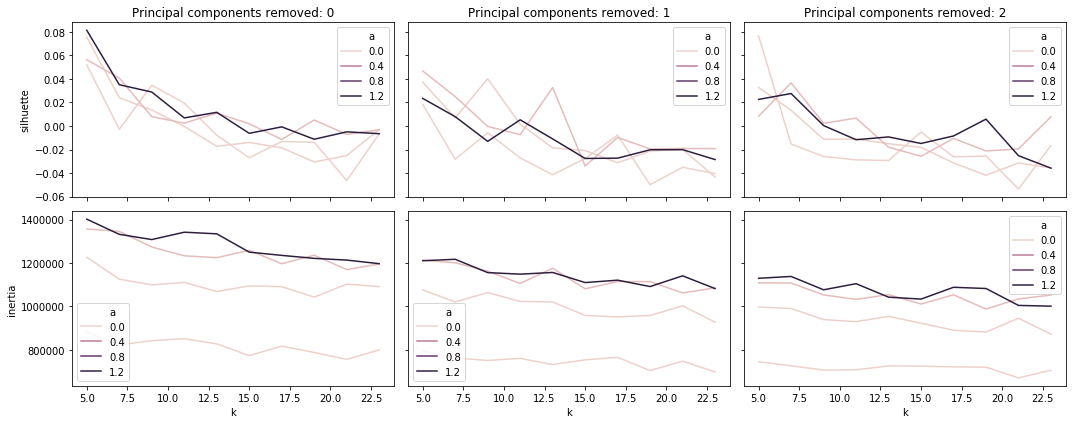

      k      a  ncomp  silhuette       inertia
4     5    0.1      1   0.046731  1.212696e+06
31    9   0.01      1   0.040125  1.063444e+06
7     5   0.01      1   0.037221  1.076073e+06
52   13    0.1      1   0.032643  1.175925e+06
16    7    0.1      1   0.025002  1.201105e+06
1     5    1.0      1   0.023444  1.210529e+06
10    5  0.001      1   0.018239  7.953209e+05
13    7    1.0      1   0.007910  1.217216e+06
19    7   0.01      1   0.006877  1.020494e+06
37   11    1.0      1   0.005228  1.148588e+06
43   11   0.01      1   0.001515  1.022820e+06
28    9    0.1      1  -0.000389  1.162287e+06
34    9  0.001      1  -0.005818  7.503905e+05
40   11    0.1      1  -0.007383  1.105810e+06
82   17  0.001      1  -0.007808  7.646316e+05
76   17    0.1      1  -0.009775  1.114375e+06
49   13    1.0      1  -0.010999  1.156389e+06
25    9    1.0      1  -0.013080  1.155700e+06
55   13   0.01      1  -0.018569  1.020223e+06
100  21    0.1      1  -0.019151  1.061995e+06
112  23    0.

In [14]:
results = pd.DataFrame(results)
results['a'] = results['a'].astype(str)
fig, ax = plt.subplots(2, 3, figsize = (15, 6), sharex = True, sharey = 'row')
ax = ax.ravel()
for i, (val, subdf) in enumerate(results.groupby('ncomp')):
    sns.lineplot(x = "k", y = "silhuette", hue = "a", ax = ax[i], data = subdf)
    ax[i].set_title(f'Principal components removed: {val}')
for i, (val, subdf) in enumerate(results.groupby('ncomp')):
    sns.lineplot(x = "k", y = "inertia", hue = "a", ax = ax[i+3], data = subdf)
plt.tight_layout()
plt.show()
print(results[results['ncomp'] == 1].sort_values('silhuette', ascending = False))

In [16]:
ktp = KTopicModel(k = 13, a = 0.1, ncomp = 1, path_embeddings = PATH_EMBEDDINGS)
ktp.fit(data.lemmatized)
glove = VectorDict().read_file(PATH_EMBEDDINGS, dim = 50)
centroid_dict  = {k:c for k, c in enumerate(glove.most_similar_by_vectors(ktp.cluster.cluster_centers_, n = 10))}
centroid_dict_noscores = {k:[w[0] for w in v] for k, v in centroid_dict.items()}

In [17]:
centroid_dict

{0: [('link', 0.80127108924438),
  ('gostio', 0.7285164594550679),
  ('linka', 0.7094644494389764),
  ('zmianaklimat', 0.6947082433174707),
  ('podawanie', 0.6881668536979895),
  ('fb', 0.6852817499717596),
  ('podesłać', 0.6843430741703143),
  ('fbot', 0.681838984879573),
  ('zróbvie', 0.6751227632521335),
  ('wideokomentarz', 0.6679428754538804)],
 1: [('o’cjonalne', 0.6423281466236884),
  ('ozzpia', 0.6371832172202835),
  ('wyjściowo', 0.6233312338954093),
  ('dodatkowy', 0.6222106294549222),
  ('bansia', 0.6172294999093886),
  ('zabezpieczenie', 0.6131436109078177),
  ('mpt', 0.6067695592367719),
  ('cyberżołnierz', 0.6063819699930225),
  ('groźej', 0.6037287772494462),
  ('defraudowanie', 0.5979670821194566)],
 2: [('półgłow', 0.8130489817095058),
  ('człeku', 0.769335379078062),
  ('osra', 0.7638812843943158),
  ('poprostu', 0.7635412987317358),
  ('huj', 0.7587101658297288),
  ('sperm', 0.7575302148196154),
  ('władyś', 0.7529320908804581),
  ('głupiaś', 0.7524571184828536),
  (